# Project: 뉴스기사 요약해보기
- Attention
- Text Summarization
- NLG

In [1]:
from importlib.metadata import version
import nltk
nltk.download("stopwords")

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
import urllib.request

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. 데이터 수집

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data_summa = data.copy()
data.sample(10)

,headlines,text
28085,Girl calls off wedding midway after lightning ...,A bride in Bihar called off her wedding midway...
37839,"Officer poses for pic with rescued snake, almo...",A forest officer was almost choked while posin...
448,US roadside assistance startup gets Ã¢ÂÂ¹149c...,US-based roadside assistance startup Urgent.ly...
47161,Black Panther earns Ã¢ÂÂ¹2331 crore in openin...,Chadwick Boseman starrer 'Black Panther' has e...
51610,Pak paid crores to abduct Jadhav from Iran: Ba...,Baloch activist Mama Qadeer has alleged that P...
25736,105 couples tie the knot in Kashmir's biggest ...,As many as 105 couples tied the knot in Kashmi...
42119,5.38 lakh of 17 lakh registered firms shut sho...,Around 5.38 lakh firms or 32% of the 17 lakh f...
70381,Zomato trolls Apple after iPhone X launch,Restaurant discovery and food ordering startup...
19185,BJP leader's drunk son runs car over sleeping ...,Rajasthan BJP leader Badri Narayan Meena's son...
79591,Old Delhi's 150-year-old Town Hall to be redev...,The North Delhi Municipal Corporation on Thurs...


## 2. 데이터 전처리

### 중복 값 및 결측치 처리

In [3]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [4]:
# 결측치 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


결측치가 없으므로 결측치 제거는 하지 않는다

### 텍스트 정규화 및 불용어 제거

In [5]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [6]:
# 불용어 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub('(<([^>]+)>)', ' ', sentence) # html 태그 제거용
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
# 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered mother father
summary: great way to start the day


In [9]:
data["text"] = data["text"].apply(lambda x: preprocess_sentence(x)).values
data["headlines"] = data["headlines"].apply(lambda x: preprocess_sentence(x, False)).values # 불용어 제거 X

In [10]:
data.replace("", np.nan, inplace=True)

In [11]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


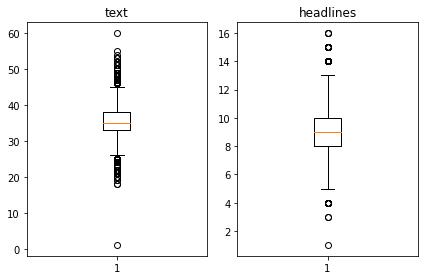

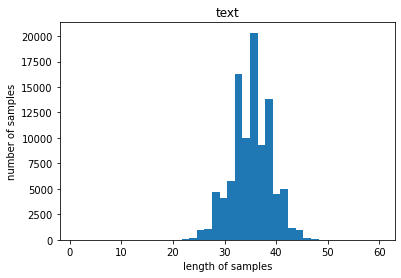

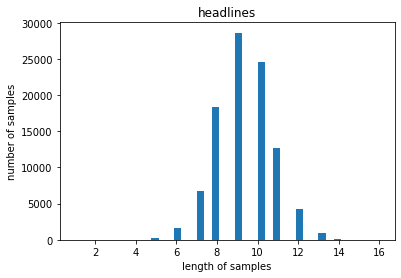

In [12]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
text_max_len = 45
headlines_max_len = 13

In [14]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [16]:
# max_len보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


### 시작 토큰과 종료 토큰 추가

In [17]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [18]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### train test split

In [19]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

[91363 73773 74979 ... 60628 27025 38691]
테스트 데이터의 수 : 19572


In [20]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 단어 집합 만들기 및 정수 인코딩

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69374
등장 빈도가 6번 이하인 희귀 단어의 수: 47357
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22017
단어 집합에서 희귀 단어의 비율: 68.2633263182172
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5153774314757644


In [22]:
src_vocab = 22100
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[151, 52, 3971, 2863, 1665, 179, 15, 1895, 366, 881, 208, 163, 222, 52, 22018, 15280, 151, 3971, 2382, 7650, 3431, 3038, 274, 482, 3266, 1895, 366, 15, 6, 321, 5577, 13325, 3732, 20551, 16603, 2173, 190, 212, 1167], [13751, 3, 13, 5156, 1924, 894, 1227, 6322, 270, 9617, 2485, 15906, 19, 199, 1835, 86, 33, 10201, 20552, 6668, 2383, 220, 1924, 894, 3754, 40, 6322, 270, 1835, 353, 270, 30, 9978, 30, 20553, 1924, 894], [517, 17392, 1137, 20554, 2286, 322, 43, 427, 87, 1182, 25, 27, 171, 42, 2, 1221, 42, 1987, 54, 144, 3322, 43, 506, 2079, 1221, 42, 427, 12508, 119, 42, 7750, 13326, 799, 964, 4320, 5115]]


In [23]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30073
등장 빈도가 5번 이하인 희귀 단어의 수: 19747
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10326
단어 집합에서 희귀 단어의 비율: 65.6635520234097
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.702659357901113


In [24]:
tar_vocab = 10400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 164, 247, 2467, 2616, 7, 18, 378, 6, 43, 1459, 57], [1, 62, 27, 165, 2523, 5, 8, 12, 2896, 28, 224], [1, 220, 251, 55, 1477, 51, 7, 2834, 51, 161, 8], [1, 695, 189, 1110, 300, 515, 7172, 12, 5400, 1874], [1, 675, 6, 15, 52, 3, 648, 204, 252, 3785, 7599]]
target
decoder  [[164, 247, 2467, 2616, 7, 18, 378, 6, 43, 1459, 57, 2], [62, 27, 165, 2523, 5, 8, 12, 2896, 28, 224, 2], [220, 251, 55, 1477, 51, 7, 2834, 51, 161, 8, 2], [695, 189, 1110, 300, 515, 7172, 12, 5400, 1874, 2], [675, 6, 15, 52, 3, 648, 204, 252, 3785, 7599, 2]]


In [25]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### padding 추가

In [26]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 3. 모델 설계

### encoder

In [27]:
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### decoder

In [28]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

### 모델 정의

In [29]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2828800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 매커니즘

In [30]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2828800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### train

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode="min", patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 62s 104ms/step - loss: 5.2659 - val_loss: 4.8767
Epoch 2/50
306/306 [==============================] - 31s 103ms/step - loss: 4.6939 - val_loss: 4.4915
Epoch 3/50
306/306 [==============================] - 32s 106ms/step - loss: 4.3691 - val_loss: 4.2428
Epoch 4/50
306/306 [==============================] - 34s 110ms/step - loss: 4.1314 - val_loss: 4.0591
Epoch 5/50
306/306 [==============================] - 34s 111ms/step - loss: 3.9414 - val_loss: 3.9330
Epoch 6/50
306/306 [==============================] - 34s 110ms/step - loss: 3.7840 - val_loss: 3.8323
Epoch 7/50
306/306 [==============================] - 34s 111ms/step - loss: 3.6488 - val_loss: 3.7533
Epoch 8/50
306/306 [==============================] - 34s 111ms/step - loss: 3.5308 - val_loss: 3.6905
Epoch 9/50
306/306 [==============================] - 34s 111ms/step - loss: 3.4292 - val_loss: 3.6388
Epoch 10/50
306/306 [==============================] - 34s 111ms/step - l

In [31]:
# recurrent dropout
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode="min", patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 225s 705ms/step - loss: 5.2720 - val_loss: 4.8256
Epoch 2/50
306/306 [==============================] - 214s 701ms/step - loss: 4.6958 - val_loss: 4.4674
Epoch 3/50
306/306 [==============================] - 214s 699ms/step - loss: 4.3906 - val_loss: 4.2379
Epoch 4/50
306/306 [==============================] - 215s 704ms/step - loss: 4.1515 - val_loss: 4.0576
Epoch 5/50
306/306 [==============================] - 213s 696ms/step - loss: 3.9585 - val_loss: 3.9303
Epoch 6/50
306/306 [==============================] - 215s 704ms/step - loss: 3.8004 - val_loss: 3.8178
Epoch 7/50
306/306 [==============================] - 215s 704ms/step - loss: 3.6662 - val_loss: 3.7402
Epoch 8/50
306/306 [==============================] - 215s 703ms/step - loss: 3.5536 - val_loss: 3.6735
Epoch 9/50
306/306 [==============================] - 214s 698ms/step - loss: 3.4508 - val_loss: 3.6186
Epoch 10/50
306/306 [==============================] - 213s 696m

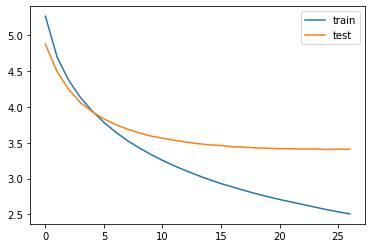

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

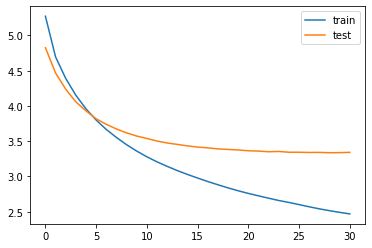

In [32]:
# recurrent dropout
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. 결과

### 인퍼런스 모델 구현

In [33]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [34]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [35]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### test

In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [38]:
for i in range(0, 10):
    print("원문:", seq2text(encoder_input_test[i]))
    print("실제 헤드라인:", seq2headlines(decoder_input_test[i]))
    print("예측 헤드라인:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문: bengaluru based food delivery startup swiggy hired management team bengaluru based asian food startup east part deal east founders joseph ghosh join swiggy team coo new supply business line founded east offers asian dishes weekly changing menu 
실제 헤드라인: swiggy hires asian food startup east 
예측 헤드라인:  swiggy to get its employees for its food delivery startup


원문: per reports virat kohli hiked endorsement fee crore day crore making highest paid brand ambassador india kohli ms dhoni actors shah rukh khan aamir khan reported charge crore per day kohli hiked fee negotiating contract renewal pepsico 
실제 헤드라인: virat kohli endorsement fee highest in india reports 
예측 헤드라인:  kohli overtakes bcci to buy stake in india reports


원문: stating israel enemies know well country capable prime minister benjamin netanyahu said whoever tries hurt us hurt netanyahu said middle east place weak weak slaughtered erased history strong good ill survive 
실제 헤드라인: tries to hurt us we hurt them israel pm neta

In [38]:
# recurrent dropout
for i in range(0, 10):
    print("원문:", seq2text(encoder_input_test[i]))
    print("실제 헤드라인:", seq2headlines(decoder_input_test[i]))
    print("예측 헤드라인:", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문: harry potter writer world highest paid author jk rowling earned million last year according forbes income surge came largely stage play harry potter cursed child second largest income came chain harry potter themed attractions universal studios hollywood us 
실제 헤드라인: harry potter author jk rowling earned million in year 
예측 헤드라인:  harry potter highest paid times in one kate


원문: exiled chinese billionaire guo accused former business partner long framing crimes says commit conviction overturned embezzling million company owned guo long said revenge find lawyer make pay added 
실제 헤드라인: chinese billionaire accused of ex business partner 
예측 헤드라인:  billionaire was billionaire


원문: rss affiliate bharatiya sangh president criticising centre policies said nda government nothing upa iii far economic labour reforms concerned added upa government thrown dustbin certain reforms due public government picked saying reforms 
실제 헤드라인: nda government nothing but upa iii rss 
예측 헤드라인:  nda govt u

## 5. Summa 이용해서 추출적 요약

In [39]:
for i in range(0, 10):
    print("원문:", data_summa['text'][i])
    print("실제 헤드라인:", data_summa['headlines'][i])
    print("예측 헤드라인:", summarize(data_summa['text'][i], ratio=0.4))
    
    print("\n")

원문: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 헤드라인: upGrad learner switches to career in ML & Al with 90% salary hike
예측 헤드라인: upGrad's Online Power Learning has powered 3 lakh+ careers.


원문: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 헤드라인: Delhi techie wins free food from Swiggy for one year on CRED
예측 헤드라인: Users get one CRED coin per rupee of bill p

대부분의 글이 두괄식 또는 미괄식으로 작성되는 특성이 반영된건지 예측 결과가 첫 문장 또는 마지막 문장이다. <br>
하지만 해당 문장이 항상 글의 전체를 대표할 수는 없다.

## Report

||Abstractive|Extractive|
|------|---|---|
|문법 완성도|△|O|
|핵심 단어 포함|O|△|


<br>

- Abstractive는 문법의 완성도는 비교적 떨어지지만 핵심 단어를 포함, 또는 실제 헤드라인과 비슷한 의미의 헤드라인을 생성해낸 것을 확인했다.
- 하지만 문법적인 측면에서는 확실히 문장 전체를 뽑는 Extractive는 완성도가 높고, 문장을 생성해내는 Abstractive는 상대적으로 문법적인 완성도가 떨어진다.

## 회고

- `BeautifulSoup`를 사용해서 html 태그를 제거한 경우 공백이 사라져 앞뒤 단어가 붙는 문제가 있어서 정규표현식으로 제거해주었다.
- recurrent dropout을 사용한 경우에 사용하지 않은 경우보다 loss가 더 떨어졌다. 하지만 학습 시간이 굉장히 오래 걸렸다.
- abstractive 방식이 완전한 문장을 생성해내지는 못했지만 좀 더 핵심 단어를 잘 뽑아낸다는 점에서 성능을 개선하면 더 쓸만하겠다고 생각했다.